In [3]:
# 0. Import and robust DATA_PATH

import os
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    brier_score_loss,
    precision_recall_curve,
    roc_curve,
)

import matplotlib.pyplot as plt

RANDOM_STATE = 42
pd.set_option("display.max_columns", 50)


cwd = Path.cwd()
print("Current working directory:", cwd)

matches = list(cwd.rglob("Software_5.json.gz"))
print("Matches found:", matches)

if not matches:
    raise FileNotFoundError(
        f"Could not find 'Software_5.json.gz' under {cwd}. "
        "Check that the file is in the repo and the name matches exactly."
    )

DATA_PATH = matches[0]  # first match
print("Using DATA_PATH:", DATA_PATH)


Current working directory: /workspaces/machine_learning_project/Analysis_Phase
Matches found: [PosixPath('/workspaces/machine_learning_project/Analysis_Phase/Software_5.json.gz')]
Using DATA_PATH: /workspaces/machine_learning_project/Analysis_Phase/Software_5.json.gz


In [4]:
# 1. Load data and basic cleaning

# Amazon review files are usually json lines with gzip compression
df = pd.read_json(DATA_PATH, lines=True, compression="gzip")

# Keep only the columns we care about
cols_keep = [
    "overall", "verified", "reviewTime", "reviewerID", "asin",
    "reviewerName", "reviewText", "summary",
    "unixReviewTime", "vote"
]
df = df[cols_keep].copy()

# ---- Clean 'vote' and define target ----
# vote is stored as strings like "3", "1,234", or may be missing
df["vote"] = df["vote"].fillna("0").astype(str).str.replace(",", "", regex=False)
df["vote"] = pd.to_numeric(df["vote"], errors="coerce").fillna(0).astype(int)

# Binary target: helpful if > 5 votes
df["helpful"] = (df["vote"] > 5).astype(int)

# ---- Clean text fields ----
df["reviewText"] = df["reviewText"].fillna("")
df["summary"] = df["summary"].fillna("")

# ---- Basic time handling ----
# unixReviewTime is seconds since epoch; ensure numeric and sort
df["unixReviewTime"] = pd.to_numeric(df["unixReviewTime"], errors="coerce")
df = df.dropna(subset=["unixReviewTime"])
df = df.sort_values("unixReviewTime").reset_index(drop=True)

print(df.head())
print(df["helpful"].value_counts(normalize=True))



   overall  verified   reviewTime      reviewerID        asin  \
0        5     False  06 26, 2000  A2G0O4Y8QE10AE  B00004TYCR   
1        4     False  08 23, 2000   ARXU3FESTWMJJ  B00003JAU7   
2        1     False  12 22, 2000   AE95Z3K6GVIC3  B00003JAU7   
3        5     False   01 4, 2001  A1P4RH7KMJ1SV2  B000050HEI   
4        5     False  01 24, 2001  A1P4RH7KMJ1SV2  B00003IRBV   

      reviewerName                                         reviewText  \
0    Deborah Woehr  I bought this program 2.5 years ago and have b...   
1  Mary Jo Sminkey  I got tired of the Win98 crashes, so decided t...   
2           S. Kim  It is worst piece of crap I ever had to instal...   
3         Molly P.  Finally! A really fun, exciting, game for girl...   
4         Molly P.  This is the second game in the Nancy Drew soft...   

                                     summary  unixReviewTime  vote  helpful  
0     An Excellent Tool for Creative Writers       961977600   269        1  
1           No

In [5]:
# 2. Feature engineering


# ---- Simple text-based scalar features ----
df["review_len_chars"] = df["reviewText"].str.len()
df["review_len_words"] = df["reviewText"].str.split().str.len()
df["summary_len_words"] = df["summary"].str.split().str.len()

df["has_exclamation"] = df["reviewText"].str.contains("!", regex=False).astype(int)
df["has_question"] = df["reviewText"].str.contains(r"\?", regex=True).astype(int)

# ---- Verified -> numeric ----
df["verified_int"] = df["verified"].astype(int)

# ---- Reviewer-level aggregate features (computed on TRAIN ONLY later) ----
# For now just keep the IDs; aggregation will happen after we split
# Same for product-level aggregates


In [6]:
# 3. Chronological Train / Val / Test split

y = df["helpful"].values
X = df.copy()   # we’ll keep all feature columns in X for now

n = len(df)
train_end = int(0.70 * n)
val_end = int(0.85 * n)

X_train = X.iloc[:train_end].copy()
y_train = y[:train_end]

X_val = X.iloc[train_end:val_end].copy()
y_val = y[train_end:val_end]

X_test = X.iloc[val_end:].copy()
y_test = y[val_end:]

print("Train/Val/Test sizes:", len(X_train), len(X_val), len(X_test))


Train/Val/Test sizes: 8963 1921 1921


In [7]:

# 4. Reviewer & product aggregate features

def build_agg_features(train_df):
    # Reviewer-level aggregates on train
    reviewer_stats = train_df.groupby("reviewerID").agg(
        reviewer_total_reviews=("overall", "size"),
        reviewer_mean_rating=("overall", "mean"),
        reviewer_mean_vote=("vote", "mean"),
    )

    # Product-level aggregates on train
    product_stats = train_df.groupby("asin").agg(
        product_total_reviews=("overall", "size"),
        product_mean_rating=("overall", "mean"),
        product_mean_vote=("vote", "mean"),
    )

    return reviewer_stats, product_stats


def merge_agg_features(X_part, reviewer_stats, product_stats):
    out = X_part.copy()

    out = out.merge(
        reviewer_stats,
        how="left",
        left_on="reviewerID",
        right_index=True,
    )
    out = out.merge(
        product_stats,
        how="left",
        left_on="asin",
        right_index=True,
    )

    # Fill missing aggregates with global means from training stats
    for col in [
        "reviewer_total_reviews", "reviewer_mean_rating", "reviewer_mean_vote",
        "product_total_reviews", "product_mean_rating", "product_mean_vote",
    ]:
        if col in out:
            out[col] = out[col].fillna(reviewer_stats[col].mean() if col in reviewer_stats.columns
                                       else product_stats[col].mean())

    return out


reviewer_stats, product_stats = build_agg_features(X_train)

X_train = merge_agg_features(X_train, reviewer_stats, product_stats)
X_val   = merge_agg_features(X_val, reviewer_stats, product_stats)
X_test  = merge_agg_features(X_test, reviewer_stats, product_stats)


In [8]:
# 5. ColumnTransformer: numeric + text

numeric_features = [
    "overall",
    "verified_int",
    "review_len_chars",
    "review_len_words",
    "summary_len_words",
    "has_exclamation",
    "has_question",
    "reviewer_total_reviews",
    "reviewer_mean_rating",
    "reviewer_mean_vote",
    "product_total_reviews",
    "product_mean_rating",
    "product_mean_vote",
]

text_feature = "summary"

numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
    ]
)

text_transformer = Pipeline(
    steps=[
        # Limit features so it fits comfortably in memory
        ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
        # PCA-like dimensionality reduction on sparse TF-IDF
        ("svd", TruncatedSVD(n_components=100, random_state=RANDOM_STATE)),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("txt", text_transformer, text_feature),
    ]
)


In [9]:
# 6. Helper functions: training + evaluation


def make_timeseries_cv(n_splits=5):
    return TimeSeriesSplit(n_splits=n_splits)


def evaluate_model(model, X, y, threshold=0.5, label=""):
    """Compute a set of metrics for a trained model."""
    y_proba = model.predict_proba(X)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    acc = accuracy_score(y, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y, y_pred, average="binary", zero_division=0
    )
    roc_auc = roc_auc_score(y, y_proba)
    pr_auc = average_precision_score(y, y_proba)
    brier = brier_score_loss(y, y_proba)
    cm = confusion_matrix(y, y_pred)

    print(f"\n=== {label} (threshold = {threshold:.3f}) ===")
    print("Accuracy:", acc)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1:", f1)
    print("ROC AUC:", roc_auc)
    print("PR AUC:", pr_auc)
    print("Brier score:", brier)
    print("Confusion matrix:\n", cm)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "brier": brier,
        "cm": cm,
        "threshold": threshold,
    }


def choose_threshold_from_val(model, X_val, y_val):
    """Pick threshold that maximizes F1 on the validation set."""
    y_proba = model.predict_proba(X_val)[:, 1]
    thresholds = np.linspace(0.1, 0.9, 33)  # 0.1, 0.12...,0.9
    best_f1 = -1
    best_thr = 0.5
    for thr in thresholds:
        y_pred = (y_proba >= thr).astype(int)
        _, _, f1, _ = precision_recall_fscore_support(
            y_val, y_pred, average="binary", zero_division=0
        )
        if f1 > best_f1:
            best_f1 = f1
            best_thr = thr
    return best_thr, best_f1


In [10]:
# 7. Model 1: K-Nearest Neighbors

knn_pipe = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", KNeighborsClassifier()),
    ]
)

tscv = make_timeseries_cv(n_splits=4)

knn_param_grid = {
    "clf__n_neighbors": [3, 5, 11],
    "clf__weights": ["uniform", "distance"],
}

knn_grid = GridSearchCV(
    knn_pipe,
    param_grid=knn_param_grid,
    cv=tscv,
    scoring="average_precision",  # PR-AUC
    n_jobs=-1,
    verbose=2,
)

knn_grid.fit(X_train, y_train)

print("Best KNN params:", knn_grid.best_params_)
knn_best = knn_grid.best_estimator_

# Choose threshold on validation set
knn_thr, knn_val_f1 = choose_threshold_from_val(knn_best, X_val, y_val)
print("KNN best validation F1:", knn_val_f1, "at threshold", knn_thr)

# Evaluate on val and test
knn_val_metrics = evaluate_model(knn_best, X_val, y_val, threshold=knn_thr, label="KNN - Validation")
knn_test_metrics = evaluate_model(knn_best, X_test, y_test, threshold=knn_thr, label="KNN - Test")


Fitting 4 folds for each of 6 candidates, totalling 24 fits


[CV] END ...........clf__n_neighbors=3, clf__weights=uniform; total time=   0.7s
[CV] END ...........clf__n_neighbors=3, clf__weights=uniform; total time=   0.7s
[CV] END ...........clf__n_neighbors=3, clf__weights=uniform; total time=   0.8s
[CV] END ...........clf__n_neighbors=3, clf__weights=uniform; total time=   0.9s
[CV] END ..........clf__n_neighbors=3, clf__weights=distance; total time=   0.4s
[CV] END ..........clf__n_neighbors=3, clf__weights=distance; total time=   0.6s
[CV] END ..........clf__n_neighbors=3, clf__weights=distance; total time=   0.7s
[CV] END ..........clf__n_neighbors=3, clf__weights=distance; total time=   0.8s
[CV] END ...........clf__n_neighbors=5, clf__weights=uniform; total time=   0.3s
[CV] END ...........clf__n_neighbors=5, clf__weights=uniform; total time=   0.4s
[CV] END ...........clf__n_neighbors=5, clf__weights=uniform; total time=   0.6s
[CV] END ..........clf__n_neighbors=5, clf__weights=distance; total time=   0.3s
[CV] END ...........clf__n_n

In [11]:
# 8. Model 2: Logistic Regression (class_weight='balanced')

log_pipe = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", LogisticRegression(
            max_iter=1000,
            class_weight="balanced",
            n_jobs=-1,
            solver="lbfgs",
        )),
    ]
)

log_param_grid = {
    "clf__C": [0.01, 0.1, 1.0, 10.0],
}

log_grid = GridSearchCV(
    log_pipe,
    param_grid=log_param_grid,
    cv=tscv,
    scoring="average_precision",  # PR-AUC
    n_jobs=-1,
    verbose=2,
)

log_grid.fit(X_train, y_train)

print("Best Logistic Regression params:", log_grid.best_params_)
log_best = log_grid.best_estimator_

# Choose threshold on validation set
log_thr, log_val_f1 = choose_threshold_from_val(log_best, X_val, y_val)
print("LogReg best validation F1:", log_val_f1, "at threshold", log_thr)

# Evaluate on val and test
log_val_metrics = evaluate_model(log_best, X_val, y_val, threshold=log_thr, label="Logistic Regression - Validation")
log_test_metrics = evaluate_model(log_best, X_test, y_test, threshold=log_thr, label="Logistic Regression - Test")


Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV] END ........................................clf__C=0.01; total time=   0.3s
[CV] END ........................................clf__C=0.01; total time=   0.4s
[CV] END ........................................clf__C=0.01; total time=   0.5s
[CV] END .........................................clf__C=0.1; total time=   0.3s
[CV] END ........................................clf__C=0.01; total time=   0.7s
[CV] END .........................................clf__C=0.1; total time=   0.4s
[CV] END .........................................clf__C=0.1; total time=   0.6s
[CV] END .........................................clf__C=1.0; total time=   0.4s
[CV] END .........................................clf__C=0.1; total time=   0.7s
[CV] END .........................................clf__C=1.0; total time=   0.4s
[CV] END .........................................clf__C=1.0; total time=   0.6s
[CV] END ........................................

In [12]:
# 9. Model 3: Small Neural Network (MLPClassifier)

mlp_pipe = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", MLPClassifier(
            hidden_layer_sizes=(64,),
            activation="relu",
            alpha=1e-3,
            batch_size=256,
            learning_rate="adaptive",
            max_iter=100,          # keep small for stability; can raise
            early_stopping=True,
            random_state=RANDOM_STATE,
        )),
    ]
)

mlp_param_grid = {
    "clf__hidden_layer_sizes": [(32,), (64,), (64, 32)],
    "clf__alpha": [1e-4, 1e-3, 1e-2],
}

mlp_grid = GridSearchCV(
    mlp_pipe,
    param_grid=mlp_param_grid,
    cv=tscv,
    scoring="average_precision",
    n_jobs=-1,
    verbose=2,
)

mlp_grid.fit(X_train, y_train)

print("Best MLP params:", mlp_grid.best_params_)
mlp_best = mlp_grid.best_estimator_

# Choose threshold on validation set
mlp_thr, mlp_val_f1 = choose_threshold_from_val(mlp_best, X_val, y_val)
print("MLP best validation F1:", mlp_val_f1, "at threshold", mlp_thr)

# Evaluate on val and test
mlp_val_metrics = evaluate_model(mlp_best, X_val, y_val, threshold=mlp_thr, label="MLP - Validation")
mlp_test_metrics = evaluate_model(mlp_best, X_test, y_test, threshold=mlp_thr, label="MLP - Test")


Fitting 4 folds for each of 9 candidates, totalling 36 fits
[CV] END ...clf__alpha=0.0001, clf__hidden_layer_sizes=(32,); total time=   0.4s
[CV] END ...clf__alpha=0.0001, clf__hidden_layer_sizes=(32,); total time=   0.6s
[CV] END ...clf__alpha=0.0001, clf__hidden_layer_sizes=(32,); total time=   0.8s
[CV] END ...clf__alpha=0.0001, clf__hidden_layer_sizes=(64,); total time=   0.6s
[CV] END ...clf__alpha=0.0001, clf__hidden_layer_sizes=(32,); total time=   2.1s
[CV] END ...clf__alpha=0.0001, clf__hidden_layer_sizes=(64,); total time=   1.4s
[CV] END ...clf__alpha=0.0001, clf__hidden_layer_sizes=(64,); total time=   1.1s
[CV] END ...clf__alpha=0.0001, clf__hidden_layer_sizes=(64,); total time=   1.1s
[CV] END clf__alpha=0.0001, clf__hidden_layer_sizes=(64, 32); total time=   0.6s
[CV] END clf__alpha=0.0001, clf__hidden_layer_sizes=(64, 32); total time=   0.9s
[CV] END clf__alpha=0.0001, clf__hidden_layer_sizes=(64, 32); total time=   1.3s
[CV] END ....clf__alpha=0.001, clf__hidden_layer_

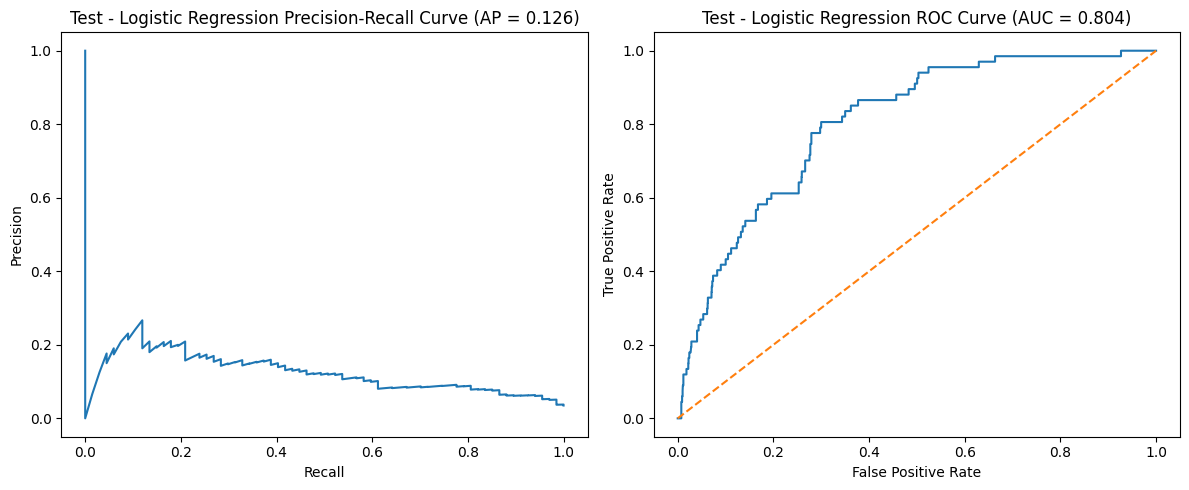

In [13]:
# 10. PR and ROC curves for the chosen model

def plot_curves(model, X, y, split_label="Test"):
    y_proba = model.predict_proba(X)[:, 1]

    # Precision-Recall
    precision, recall, _ = precision_recall_curve(y, y_proba)
    pr_auc = average_precision_score(y, y_proba)

    # ROC
    fpr, tpr, _ = roc_curve(y, y_proba)
    roc_auc = roc_auc_score(y, y_proba)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{split_label} Precision-Recall Curve (AP = {pr_auc:.3f})")

    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{split_label} ROC Curve (AUC = {roc_auc:.3f})")

    plt.tight_layout()
    plt.show()


# Example: curves for best logistic model on test
plot_curves(log_best, X_test, y_test, split_label="Test - Logistic Regression")


In [1]:
import pandas as pd

data = {
    "Model": ["KNN", "Logistic Regression", "MLP Neural Network"],
    "Accuracy (Test)": [0.930244664, 0.872982821, 0.809994974],
    "Precision": [0.123955, 0.129707, 0.079096],
    "Recall": [0.164176, 0.462865, 0.419791],
    "F1": [0.140216, 0.202634, 0.133017],
    "ROC-AUC": [0.744366, 0.804396, 0.744356],
    "PR-AUC": [0.0670065, 0.126437, 0.099509],
    "Threshold": [0.35, 0.475, 0.25]
}

df_results = pd.DataFrame(data)
df_results


,Model,Accuracy (Test),Precision,Recall,F1,ROC-AUC,PR-AUC,Threshold
0,KNN,0.930245,0.123955,0.164176,0.140216,0.744366,0.067006,0.350
1,Logistic Regression,0.872983,0.129707,0.462865,0.202634,0.804396,0.126437,0.475
2,MLP Neural Network,0.809995,0.079096,0.419791,0.133017,0.744356,0.099509,0.250
